In [19]:
import pandas as pd
import numpy as np
import os
import os.path
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, LogisticRegression, LassoCV, LinearRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import bootstrap
from src.utils.data import getDataPandas, getConfig
from pipe.lut import Model_LUT, Metrics_LUT, Feature_LUT, Plot_LUT
from pipe.stats import stats_analyze
from mrmr import mrmr_classif, mrmr_regression
import sys
from io import StringIO

In [20]:
# None-image features
data = getDataPandas()
model_config = getConfig('model')
data_config = getConfig('data')
img_config = getConfig('image')
group = data_config['data_group']

# Tasks include models used
TASKS = [
    'classification/5'
]
# Features include image features used
FEATURES = [
    ['tiv_gmv', 't1_radiomic'],
]

# Maybe write to a specific file later?
log_func = print
rst = {}
auc_dist = {}

In [21]:
rdn_list = [i for i in range(20)]
auc_list = np.zeros((2, 2, 2, 20))

In [25]:
for rdn_idx in range(len(rdn_list)):
    # Loop for tasks and feature collections
    for task_name in TASKS:
        log_func('Current Task: {}'.format(task_name))
        log_func()
        for feature_names in FEATURES:
            log_func('Image Features:\n {}'.format(feature_names))
            log_func()
            # Get model list
            task = model_config['task'][task_name]
            models = task['models']
            metric_list = task['metrics']
        
            # Filter data with demographic and clinical keys
            x = data[group['demo'] + group['clinic']]
            y = data[[task['output']]]
            # Split the dataset
            train_inds = data_config['train_cat5_index']
            test_inds = data_config['test_cat5_index']
            x_clinic_train = x.iloc[train_inds].reset_index(drop=True)
            x_clinic_test = x.iloc[test_inds].reset_index(drop=True)
            y_train = y.iloc[train_inds].reset_index(drop=True).astype(int)
            y_test = y.iloc[test_inds].reset_index(drop=True).astype(int)
            # Statistical Analysis
            stats_analyze(x_clinic_train, x_clinic_test, y_train, y_test, data_config)
            # Empty dataframes to fill with image features
            x_img_train = pd.DataFrame(index=x_clinic_train.index).reset_index(drop=True)
            x_img_test = pd.DataFrame(index=x_clinic_test.index).reset_index(drop=True)

            # Loop to calculate each feature, multiple features are supported
            for feature_name in feature_names:
                # Get calculation function and params via LUT
                func = Feature_LUT[feature_name]
                params = img_config['task'][feature_name]['params']
                # Calculate features and append to the dataframe
                x_fe_train, x_fe_test = func(data, train_inds, test_inds, params)
                x_img_train = x_img_train.join(x_fe_train.reset_index(drop=True))
                x_img_test = x_img_test.join(x_fe_test.reset_index(drop=True))

            # Normalization
            scaler = MinMaxScaler()
            x_img_train = pd.DataFrame(scaler.fit_transform(x_img_train, y_train), columns=x_img_train.columns)
            x_img_test = pd.DataFrame(scaler.transform(x_img_test), columns=x_img_test.columns)
        
            ## Feature Selection
            ## WIP
        
            isContinuous = task['continuous']
        
            ##mRMR
            selected = mrmr_classif(X=x_img_train, y=y_train, K=50) if not isContinuous else mrmr_regression(X=x_img_train, y=y_train, K=50)
        
            #est = LogisticRegression(penalty='elasticnet', solver='saga', random_state=1, l1_ratio=0.5)
            est = LogisticRegression(penalty='l1', solver='saga', random_state=1)
            #est = LogisticRegression(random_state=1)
            selector = RFECV(est, min_features_to_select=1, cv=5, step=1)
            selector = selector.fit(X=x_img_train[selected], y=y_train)
            selected = np.array(selected)[selector.get_support()]
            n_scores = len(selector.cv_results_["mean_test_score"])
            # plt.errorbar(
            #     range(1, n_scores+1),
            #     selector.cv_results_["mean_test_score"],
            #     yerr=selector.cv_results_["std_test_score"],
            # )
            # plt.xticks(range(1,n_scores+1))
            # plt.xlabel("Number of features selected")
            # plt.ylabel("Mean test accuracy")
            # plt.show()
            # coef = selector.estimator_.coef_[0]
            # sort_idx = coef.argsort()
            # plt.barh(selected[sort_idx], coef[sort_idx])
            # plt.xlabel('Importance')
            # plt.show()
            #selector = selector.fit(X=x_img_train, y=y_train)
            #selected = np.array(x_img_train.columns)[selector.get_support()]

        
            log_func('Selected features: {}'.format(selected))
            log_func()
            x_img_train = x_img_train[selected]
            x_img_test = x_img_test[selected]

            # Rearrange data
            # demo + clinic, demo + img, demo + clinic + img
            x_clinic_train = x_clinic_train.reset_index(drop=True)
            x_clinic_test = x_clinic_test.reset_index(drop=True)
            x_demo_train = x_clinic_train[group['demo']]
            x_demo_test = x_clinic_test[group['demo']]
            x_clinic_img_train = x_clinic_train.join(x_img_train)
            x_clinic_img_test = x_clinic_test.join(x_img_test)
            # No demo data in img df
            x_img_train = x_demo_train.join(x_img_train)
            x_img_test = x_demo_test.join(x_img_test)

            x_train_list = [x_clinic_train, x_clinic_img_train]
            x_test_list = [x_clinic_test, x_clinic_img_test]
            info_list = ['Demo + Clinic:', 'Demo + Clinic + Img:']
        
            #x_train_list = [x_clinic_img_train]
            #x_test_list = [x_clinic_img_test]
            #info_list = ['Demo + Clinic + Img:']
        
            #selected = ['rTHA_original_gldm_LargeDependenceHighGrayLevelEmphasis']

            # Loop
            for i in range(len(info_list)):
                x_train = x_train_list[i]
                x_test = x_test_list[i]
                scaler = MinMaxScaler()
                x_train = pd.DataFrame(scaler.fit_transform(x_train, y_train), columns=x_train.columns)
                x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)
                log_func(info_list[i])
                log_func()
                for model_idx in range(len(models)):
                    model = models[model_idx]
                    name = model['name']
                    parameters = model['params']
                    model = Model_LUT[name]
                    parameters['random_state'] = [rdn_list[rdn_idx]]
                    cv = GridSearchCV(
                        model(),
                        parameters,
                        n_jobs=5,
                        #fit_params={'eval_set':[(x_test, y_test.values.ravel())]},
                        # StratifiedGroupKFold?
                        cv=(StratifiedKFold(n_splits=5, shuffle=True, random_state=1) if task['stratify'] else KFold(n_splits=5, shuffle=True, random_state=1)),
                        scoring=task['gridsearch_params']['scoring']
                    )
                    
                    cv.fit(x_train, y_train.values.ravel())
                    model_instance = model(**cv.best_params_)
                    model_instance.fit(x_train, y_train.values.ravel())
                
                    log_func('Model: {}'.format(name))
                    # Now classification specific, other metrics need to be considered according to task
                    for metric in metric_list:
                        metric_func = Metrics_LUT[metric[0]]
                        # predict_proba True
                        # predic        False
                        pred_func = model_instance.predict_proba if metric[1] else model_instance.predict
                        train_pred = pred_func(x_train)
                        test_pred = pred_func(x_test)
                        auc_train = metric_func(y_true=y_train, y_score=train_pred, multi_class='ovr')
                        auc_test = metric_func(y_true=y_test, y_score=test_pred, multi_class='ovr')
                        auc_list[model_idx][i][0][rdn_idx] = auc_train
                        auc_list[model_idx][i][1][rdn_idx] = auc_test
                        # print('AUC train {}, test {}'.format(
                        #     auc_train,
                        #     auc_test))

                    plot_list = task['plot']
                    #for plot in plot_list:
                        # plot_func = Plot_LUT[plot[0]]
                        # pred_func = model_instance.predict_proba if plot[1] else model_instance.predict
                        # train_pred = pred_func(x_train)
                        # test_pred = pred_func(x_test)
                        # plot_func(y_train[task['output']].to_numpy(), train_pred)
                        # plt.show()
                    
                        # plot_func = Plot_LUT[plot[0]]
                        # pred_func = model_instance.predict_proba if plot[1] else model_instance.predict
                        # train_pred = pred_func(x_train)
                        # test_pred = pred_func(x_test)
                        # plot_func(y_test[task['output']].to_numpy(), test_pred)
                        # plt.show()
                log_func()

Current Task: classification/5

Image Features:
 ['tiv_gmv', 't1_radiomic']

SEX chi2 p: 0.5772326031544939
AGE_AT_VISIT Normaltest p_train: [0.05740598], p_test: [0.48166696]
AGE_AT_VISIT t-test p: Ttest_indResult(statistic=array([-0.05537471]), pvalue=array([0.95589089]))
NUPDR3OF Normaltest p_train: [0.01895273], p_test: [0.05125505]
NUPDR3OF ranksums p: RanksumsResult(statistic=array([0.09049255]), pvalue=array([0.92789581]))
LEDD Normaltest p_train: [4.6194767e-12], p_test: [0.31716459]
LEDD ranksums p: RanksumsResult(statistic=array([0.45113199]), pvalue=array([0.65189442]))
DURATION Normaltest p_train: [0.00273752], p_test: [0.32684127]
DURATION ranksums p: RanksumsResult(statistic=array([-0.46177817]), pvalue=array([0.64424041]))



100%|██████████| 50/50 [00:01<00:00, 29.81it/s]


Selected features: ['rTHA_original_gldm_LargeDependenceHighGrayLevelEmphasis'
 'lSN_original_glszm_SmallAreaLowGrayLevelEmphasis'
 'rCAU_original_firstorder_Kurtosis'
 'rGPe_original_gldm_SmallDependenceHighGrayLevelEmphasis']

Demo + Clinic:



TypeError: GridSearchCV.__init__() got an unexpected keyword argument 'fit_params'

In [ ]:
print(auc_list[0][0][0])
print(auc_list[0][0][1])
print(auc_list[0][1][0])
print(auc_list[0][1][1])

[0.77610421 0.7679668  0.77671208 0.78772284 0.76914414 0.76435129
 0.77390638 0.7719315  0.7721784  0.77966386 0.77856373 0.74995803
 0.76694371 0.78239213 0.79240347 0.78184123 0.78425142 0.77429329
 0.76749908 0.77264749]
[0.61095238 0.60115079 0.63109127 0.62384921 0.60051587 0.58759921
 0.61198413 0.62767857 0.62287698 0.60529762 0.61819444 0.59200397
 0.59315476 0.64021825 0.63253968 0.61587302 0.62619048 0.60628968
 0.61087302 0.60339286]
[0.74538002 0.74822379 0.74050346 0.74408498 0.73554734 0.72053767
 0.74036829 0.73876314 0.74572627 0.74646794 0.72339652 0.73668201
 0.74485248 0.74182598 0.74646359 0.74303085 0.74673751 0.74052728
 0.74126014 0.74487214]
[0.64210317 0.63188492 0.64781746 0.65093254 0.59700397 0.6246627
 0.64769841 0.65694444 0.6447619  0.63347222 0.6372619  0.61277778
 0.64978175 0.6468254  0.64464286 0.63452381 0.65       0.63944444
 0.6425     0.62184524]


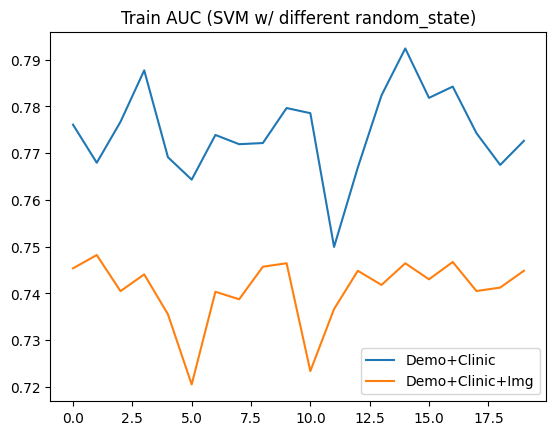

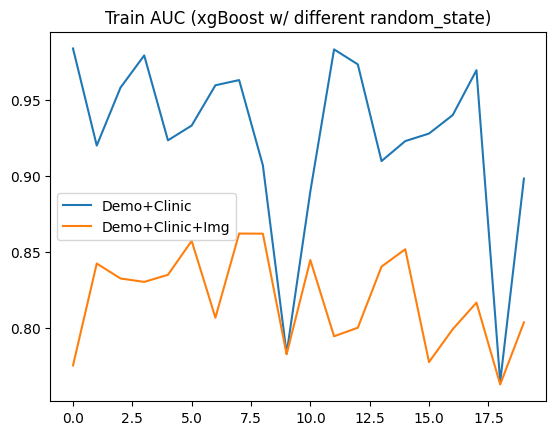

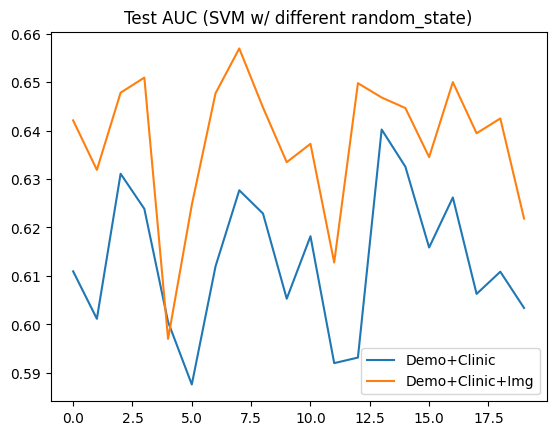

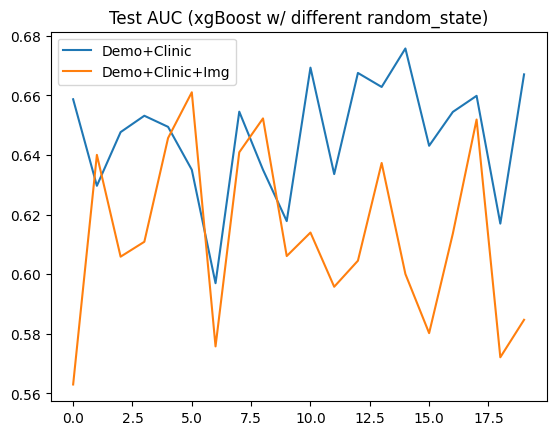

In [ ]:
plt.plot(auc_list[0][0][0])
plt.plot(auc_list[0][1][0])
plt.legend(['Demo+Clinic', 'Demo+Clinic+Img'])
plt.title('Train AUC (SVM w/ different random_state)')
plt.show()
plt.plot(auc_list[1][0][0])
plt.plot(auc_list[1][1][0])
plt.legend(['Demo+Clinic', 'Demo+Clinic+Img'])
plt.title('Train AUC (xgBoost w/ different random_state)')
plt.show()
plt.plot(auc_list[0][0][1])
plt.plot(auc_list[0][1][1])
plt.legend(['Demo+Clinic', 'Demo+Clinic+Img'])
plt.title('Test AUC (SVM w/ different random_state)')
plt.show()
plt.plot(auc_list[1][0][1])
plt.plot(auc_list[1][1][1])
plt.legend(['Demo+Clinic', 'Demo+Clinic+Img'])
plt.title('Test AUC (xgBoost w/ different random_state)')
plt.show()